# Evalutation statistique : régression logistique
## Library

In [1]:
import numpy as np
import pandas as pd
from sas7bdat import SAS7BDAT

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot


import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import pearsonr, ttest_ind

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve


## DataFrame

In [2]:
file_path = './data/individus_ct2013.sas7bdat'
with SAS7BDAT(file_path) as reader:
    df = reader.to_data_frame()
df.info()

[individus_ct2013.sas7bdat] column count mismatch


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33673 entries, 0 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 139.0+ MB


## Périmètre de l'étude
* On s'intérresse uniquement aux individus vivant en couple dans le même logement. 

In [3]:
df = df.query('COUPLE == "1"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Columns: 541 entries, C1C to revmenscc_drap
dtypes: float64(76), object(465)
memory usage: 99.3+ MB


## Variable dépendante binaire

In [4]:
df['FPA'] = df.apply(lambda row: 1 if (row['PRACT'] == '1' and row['SEXE'] == '2') else 0, axis=1)      # Créer la nouvelle colonne 'femme_principal_apporteur' avec des valeurs 1 ou 0

nb_FPA = df['FPA'].sum()        # Compter le nombre de lignes où 'femme_principal_apporteur' est égal à 1

print("Nombre de lignes où 'femme_principal_apporteur' est égal à", nb_FPA)

Nombre de lignes où 'femme_principal_apporteur' est égal à 5080


## Sélection des variables

In [5]:
variables_dict = {
    'etat_civil_familial': ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E'],
    'situation_travail': ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER',],
    'revenus_conditions_vie': ['REVMENUC', 'AIDFAM'], 
    'caracteristiques_logement_familial': ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS'],
    'ajout': ['LIENPREF', 'LIEN_01', 'AGEQ', 'TRANCHRE']
}

# Accès aux listes individuelles
print("* Etat civil et familial:", variables_dict['etat_civil_familial'])
print("* Situation travail:", variables_dict['situation_travail'])
print("* Revenus et conditions de vie:", variables_dict['revenus_conditions_vie'])
print("* Caractéristiques du logement et familial:", variables_dict['caracteristiques_logement_familial'])

* Etat civil et familial: ['ANAIS', 'ETAMATRI', 'PACS', 'MER1E', 'PER1E']
* Situation travail: ['SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER']
* Revenus et conditions de vie: ['REVMENUC', 'AIDFAM']
* Caractéristiques du logement et familial: ['TYPOLOG', 'TYPMEN15', 'NPERS', 'NACTIFS']


### Identification des types de variables

In [6]:
explicatives = [var for sublist in variables_dict.values() for var in sublist]

numericals = [var for var in explicatives if pd.api.types.is_numeric_dtype(df[var]) or pd.api.types.is_datetime64_any_dtype(df[var])]
categoricals = [var for var in explicatives if isinstance(df[var].dtype, pd.CategoricalDtype) or df[var].dtype == 'object']
target = ['FPA']

print(f"numericals: {numericals}")
print(f"categoricals: {categoricals}")

columns_to_keep = numericals + categoricals + target
df = df[columns_to_keep]

numericals: ['ANAIS', 'REVMENUC', 'NPERS', 'NACTIFS']
categoricals: ['ETAMATRI', 'PACS', 'MER1E', 'PER1E', 'SITUA', 'CJSITUA', 'RABS', 'STATUTEXT', 'METIER', 'AIDFAM', 'TYPOLOG', 'TYPMEN15', 'LIENPREF', 'LIEN_01', 'AGEQ', 'TRANCHRE']


### Nettoyage

In [7]:
df.replace('', 0, inplace=True)
df.replace(' ', 0, inplace=True)
df.fillna(0, inplace=True)

nan_count = df.isna().sum()
zero_count = (df == 0).sum()

print("Nombre de NaN par colonne :")
print(nan_count)

print("\nNombre de 0 par colonne :")
print(zero_count)

df.head(20)

Nombre de NaN par colonne :
ANAIS        0
REVMENUC     0
NPERS        0
NACTIFS      0
ETAMATRI     0
PACS         0
MER1E        0
PER1E        0
SITUA        0
CJSITUA      0
RABS         0
STATUTEXT    0
METIER       0
AIDFAM       0
TYPOLOG      0
TYPMEN15     0
LIENPREF     0
LIEN_01      0
AGEQ         0
TRANCHRE     0
FPA          0
dtype: int64

Nombre de 0 par colonne :
ANAIS            0
REVMENUC      1035
NPERS          112
NACTIFS         78
ETAMATRI         0
PACS         17004
MER1E           18
PER1E           38
SITUA            4
CJSITUA          4
RABS         21471
STATUTEXT    19078
METIER           0
AIDFAM       23932
TYPOLOG          0
TYPMEN15         0
LIENPREF         4
LIEN_01          0
AGEQ             0
TRANCHRE     17755
FPA          18944
dtype: int64


,ANAIS,REVMENUC,NPERS,NACTIFS,ETAMATRI,PACS,MER1E,PER1E,SITUA,CJSITUA,...,STATUTEXT,METIER,AIDFAM,TYPOLOG,TYPMEN15,LIENPREF,LIEN_01,AGEQ,TRANCHRE,FPA
2,1963.0,766.666667,5.0,2.0,2,0,3,2,4,1,...,0,2,1,1,42,01,01,45,0,0
3,1969.0,0.000000,2.0,1.0,2,0,2,3,1,6,...,0,2,0,1,31,00,00,40,1,0
5,1971.0,785.714286,4.0,2.0,2,0,2,3,1,4,...,0,1,0,1,42,00,01,40,7,0
6,1948.0,1466.666667,2.0,2.0,2,0,3,3,1,1,...,0,2,0,1,32,01,00,60,0,0
7,1961.0,292.608696,4.0,1.0,1,2,2,2,1,6,...,0,2,0,1,41,00,00,50,0,0
9,1976.0,625.000000,5.0,2.0,2,0,2,2,1,4,...,0,2,0,1,42,00,00,35,0,0
11,1959.0,450.000000,3.0,3.0,2,0,2,2,1,1,...,0,2,0,1,42,00,01,50,0,1
15,1966.0,1029.411765,7.0,1.0,2,0,2,2,1,6,...,0,1,0,1,41,00,00,45,0,0
18,1958.0,2666.666667,2.0,2.0,1,1,2,2,1,1,...,0,9,0,1,32,01,01,50,0,0
19,1963.0,1300.000000,3.0,2.0,2,0,2,1,1,1,...,0,2,0,1,52,00,00,45,0,0


## Distribution

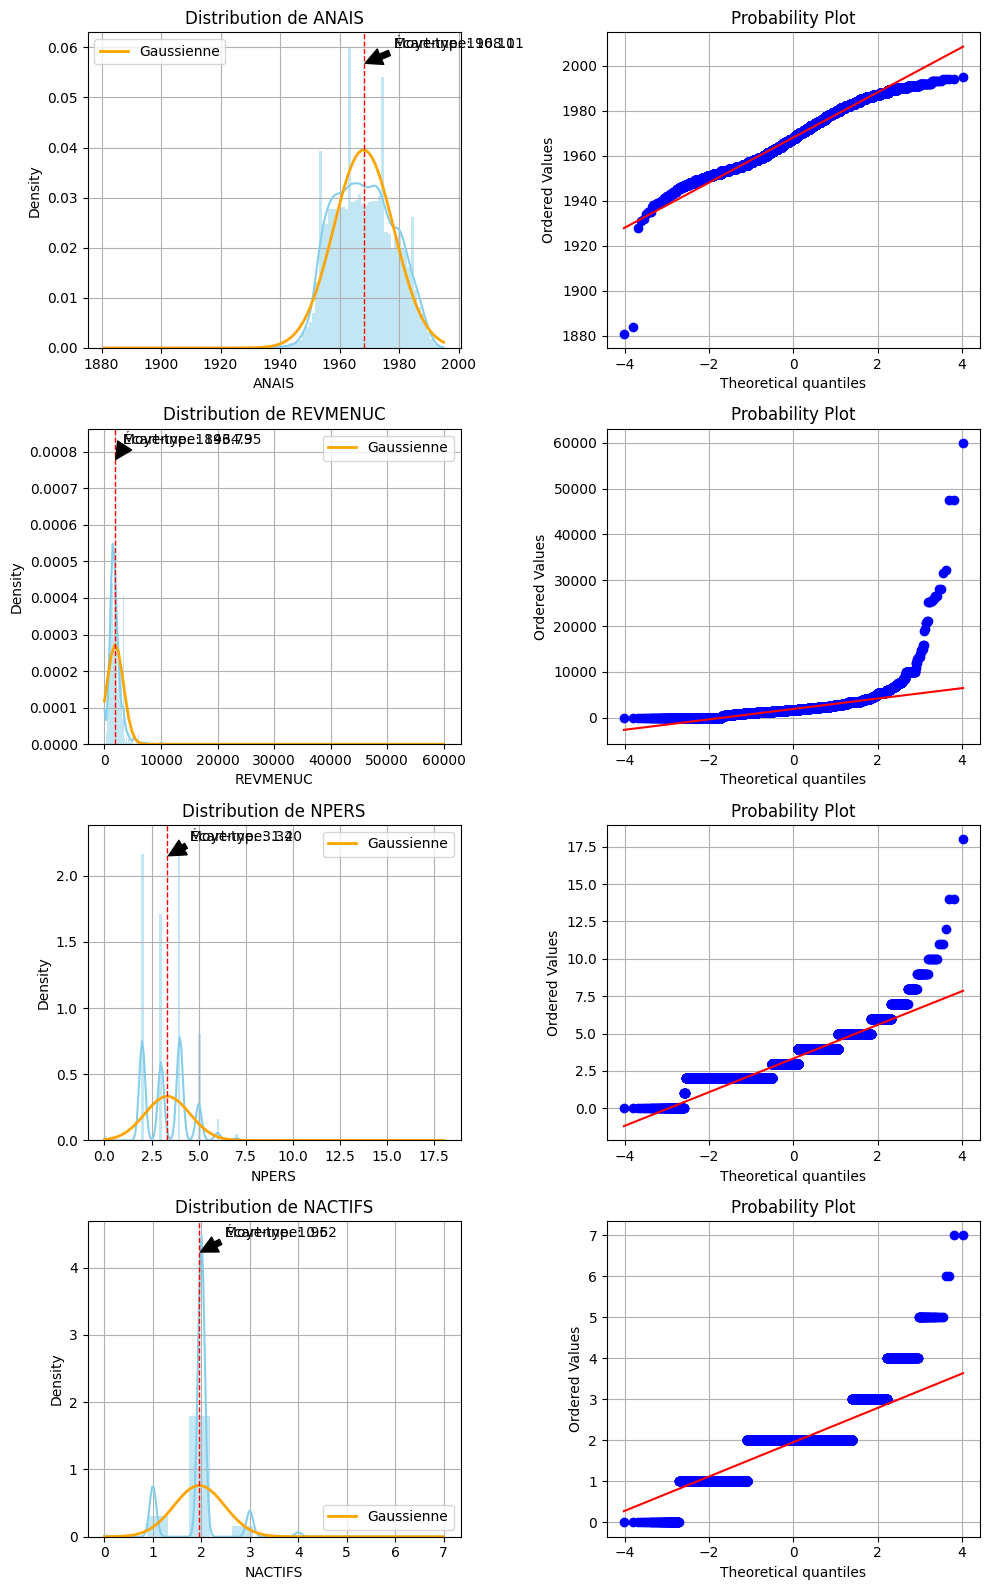

In [8]:
def plot_continuous_variables(df, numericals):
    # Créer une grille de sous-plots avec 2 colonnes
    num_vars = len(numericals)
    fig, axes = plt.subplots(num_vars, 2, figsize=(10, 4*num_vars))
    
    for i, var in enumerate(numericals):
        # Distribution de la variable (courbe de Gauss)
        ax = axes[i, 0]
        ax.set_title(f'Distribution de {var}')
        ax.grid(True)
        
        # Utiliser seaborn pour un tracé rapide de la distribution (peut utiliser d'autres bibliothèques selon votre choix)
        sns.histplot(df[var], kde=True, ax=ax, color='skyblue', stat='density', linewidth=0)
        
        # Tracer la courbe de Gauss correspondante
        xmin, xmax = df[var].min(), df[var].max()
        mean, std_dev = df[var].mean(), df[var].std()
        x = np.linspace(xmin, xmax, 100)
        ax.plot(x, stats.norm.pdf(x, mean, std_dev), label='Gaussienne', color='orange', linewidth=2)
        ax.legend(prop={'size': 10})
        
        # Ajouter des annotations pour la moyenne et l'écart-type
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1)
        ax.annotate(f'Moyenne: {mean:.2f}', xy=(mean, ax.get_ylim()[1]*0.9), xytext=(mean + std_dev, ax.get_ylim()[1]*0.95),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        ax.annotate(f'Écart-type: {std_dev:.2f}', xy=(mean + std_dev, ax.get_ylim()[1]*0.95))
        
        # Q-Q plot de la variable
        ax = axes[i, 1]
        ax.set_title(f'Q-Q plot de {var}')
        ax.grid(True)
        
        # Utiliser scipy.stats pour calculer le Q-Q plot
        stats.probplot(df[var], dist="norm", plot=ax)
        
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    plt.show()

plot_continuous_variables(df, numericals)

## Analyse des dépendances
### (1) Numericals____
####    Analyse de corrélation

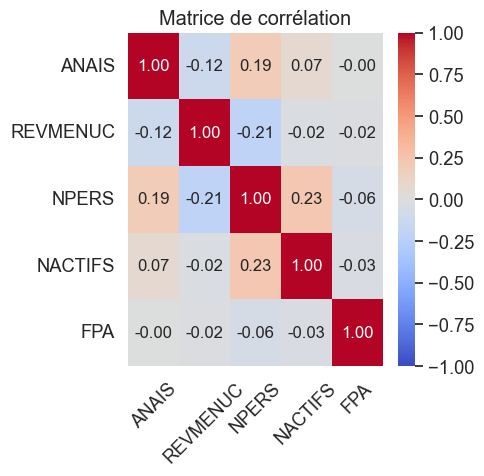

In [9]:
def plot_correlation_matrix(df, numericals, target):

    corr_matrix = df[numericals + target].corr()
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1.2)
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
    
    # Ajouter le titre et ajuster les marges
    plt.title('Matrice de corrélation')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Afficher le plot
    plt.show()

plot_correlation_matrix(df, numericals, target)

####    Test de Student
    - Hypothèse nulle (H0) : Il n'y a pas de différence significative entre les moyennes des variables continues pour les groupes définis par la variable 'FPA'.
    - Hypothèse alternative (H1) : Il y a une différence significative entre les moyennes des variables continues pour les groupes définis par la variable 'FPA'.

In [10]:
def test_association_with_fpa(df, numericals, target, alpha=0.05):
    print("___Test de Student___\n")   

    new_columns = numericals + target
    groups = df[new_columns].groupby(target)
    group0 = groups.get_group((0,))
    group1 = groups.get_group((1,))


    results = []

    for var in numericals:
        t_stat, p_value = stats.ttest_ind(group0[var], group1[var], equal_var=False)

        # Interpréter les résultats
        if np.isnan(p_value):
            significatif = "NaN"
        elif p_value < alpha:
            significatif = "yes"
        else:
            significatif = "no"
        
        # Ajouter les résultats à la liste results
        results.append({
        'Variable': var,
        'Statistique t': t_stat,
        'Valeur p': p_value,
        'Significatif': significatif, 
        'Impact': abs(t_stat)
        })
    
    results_sorted = sorted(results, key=lambda x: x['Impact'], reverse=True)
    df_results = pd.DataFrame(results_sorted)
    df_styled = df_results.style.apply(lambda row: ['background-color: lightgreen' if x == 'yes' else '' for x in row], axis=1)

    impactful_variables = df_results[df_results['Significatif'] == 'yes']['Variable'].tolist()
    print(f"Variables significatives: {impactful_variables}")

    return df_styled
        
test_association_with_fpa(df, numericals, target, alpha=0.05)

___Test de Student___

Variables significatives: ['NPERS', 'NACTIFS', 'REVMENUC']


,Variable,Statistique t,Valeur p,Significatif,Impact
0,NPERS,9.867643,0.000000,yes,9.867643
1,NACTIFS,5.250738,0.000000,yes,5.250738
2,REVMENUC,3.318431,0.000909,yes,3.318431
3,ANAIS,0.480623,0.630798,no,0.480623


#### Selection numercials_

In [11]:
# Filtrage des variables continues
numericals = ['NPERS', 'NACTIFS', 'REVMENUC']

new_columns = numericals + categoricals + target 
df = df[new_columns].copy()

### (2) Categoricals____
#### Tableaux de contingence     

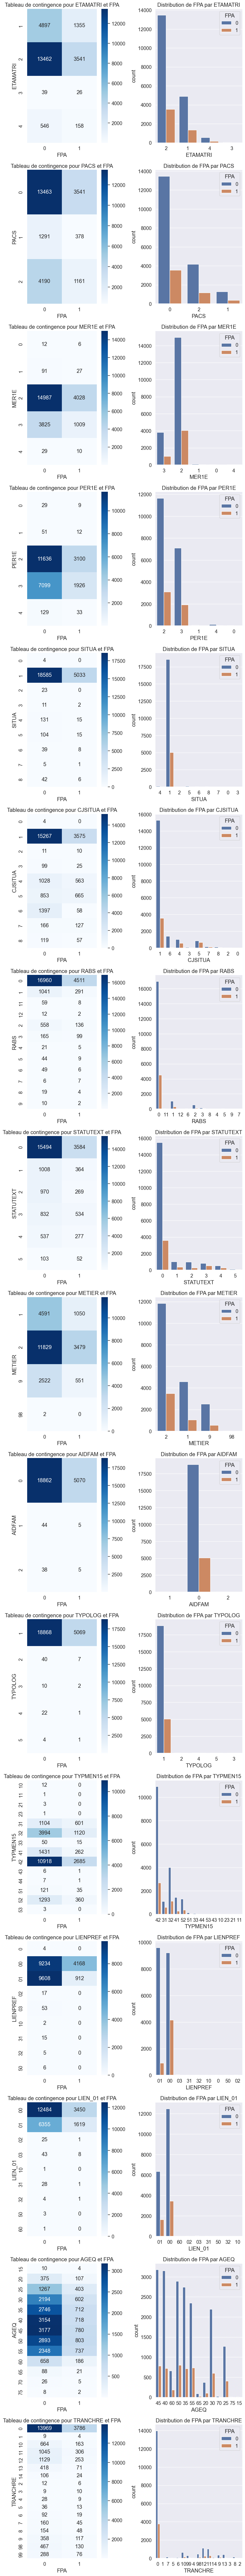

In [12]:
def create_contingency_tables(df, categoricals, target='FPA'):

    num_categoricals = len(categoricals)
    fig, axs = plt.subplots(num_categoricals, 2, figsize=(9, num_categoricals * 6))
    
    for i, var in enumerate(categoricals):
        # Créer un tableau de contingence entre la variable catégorielle et 'FPA'
        contingency_table = pd.crosstab(df[var], df[target])
        
        # Afficher le tableau de contingence à gauche
        axs[i, 0].set_title(f'Tableau de contingence pour {var} et {target}')
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axs[i, 0])
        
        # Créer un graphique à droite montrant la distribution de 'FPA' par catégorie de la variable catégorielle
        sns.countplot(x=var, hue=target, data=df, ax=axs[i, 1])
        axs[i, 1].set_title(f'Distribution de {target} par {var}')
        axs[i, 1].legend(title=target)
        
        # Ajuster l'espacement entre les subplots
        plt.tight_layout()
    
    # Afficher les graphiques
    plt.show()

create_contingency_tables(df, categoricals, target='FPA')

#### Test du χ² pour évaluer leur association avec la variable dépendante. 

    - Hypothèse nulle (H0) : Il n'y a pas de relation entre la variable catégorielle et la variable cible 'FAP'.
    - Hypothèse alternative (H1) : Il y a une relation entre la variable catégorielle et la variable cible 'FAP'.

In [13]:
def khi2_test_association(df, categoricals, target='FAP', alpha=0.05):
    print("___Test du Khi2___\n")   
    results = []
    
    for var in categoricals:
        # Créer un tableau de contingence entre la variable catégorielle et 'FAP'
        contingency_table = pd.crosstab(df[var], df[target])
        
        # Effectuer le test du chi-deux
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        # Interpréter les résultats
        if p_value < alpha:
            impact = 'Yes'
        else:
            impact = 'No'
        
        # Ajouter les résultats à la liste
        results.append({
            'variable': var,
            'statistique': chi2,
            'p-value': p_value,
            'impact': impact
        })
            
    results_sorted = sorted(results, key=lambda x: x['statistique'], reverse=True)
    df_results = pd.DataFrame(results_sorted)  

    # Filtrer les variables dont l'impact est 'Yes'
    impactful_variables = df_results[df_results['impact'] == 'Yes']['variable'].tolist()
    
    # Imprimer la liste des variables avec impact 'Yes'
    print("Categoricals with statistical significatif impact:", impactful_variables)
    
    # Appliquer le style conditionnel pour mettre en évidence les lignes avec impact == 'Yes'
    df_styled = df_results.style.apply(lambda row: ['background-color: lightgreen' if x == 'Yes' else '' for x in row], axis=1)
    
    return df_styled

khi2_test_association(df, categoricals, target='FPA', alpha=0.05)


___Test du Khi2___

Categoricals with statistical significatif impact: ['LIENPREF', 'CJSITUA', 'STATUTEXT', 'TYPMEN15', 'METIER', 'RABS', 'AGEQ', 'TRANCHRE', 'SITUA', 'LIEN_01', 'ETAMATRI']


,variable,statistique,p-value,impact
0,LIENPREF,1805.855593,0.000000,Yes
1,CJSITUA,1081.203884,0.000000,Yes
2,STATUTEXT,446.994010,0.000000,Yes
3,TYPMEN15,260.563617,0.000000,Yes
4,METIER,64.225270,0.000000,Yes
5,RABS,60.517425,0.000000,Yes
6,AGEQ,46.995852,0.000005,Yes
7,TRANCHRE,43.617937,0.000225,Yes
8,SITUA,26.140004,0.000994,Yes
9,LIEN_01,18.210116,0.019705,Yes


#### Test ANOVA (Analyse de variance)
        - H0 (hypothèse nulle) : Les moyennes des groupes définis par la variable catégorielle sont égales.
        - H1 (hypothèse alternative) : Au moins une paire de moyennes des groupes est différente.

In [14]:
def anova_test(df, categoricals, target='FPA', alpha=0.05):
    print("___Test ANOVA___\n")  
    results = []
    
    for var in categoricals:
        # Collecter les données pour l'ANOVA
        groups = []
        for category in df[var].unique():
            group_data = df[df[var] == category][target]
            groups.append(group_data)
        
        # Effectuer l'ANOVA
        f_statistic, p_value = stats.f_oneway(*groups)
        
        # Interpréter les résultats
        if p_value < alpha:
            result = 'Yes'
        else:
            result = 'No'
        
        # Ajouter les résultats à la liste
        results.append({
            'variable': var,
            'statistique F': f_statistic,
            'p-value': p_value,
            'result': result
        })

    results_sorted = sorted(results, key=lambda x: x['statistique F'], reverse=True)   
    df_results = pd.DataFrame(results_sorted)
    
    # Appliquer le style conditionnel pour mettre en évidence les lignes avec result == 'Yes'
    def highlight_yes(s):
        return ['background-color: lightgreen' if v == 'Yes' else '' for v in s]
    
    styled_df = df_results.style.apply(highlight_yes, subset=['result'])

    # Afficher les variables dont la p-value est inférieure à 0,05
    significant_vars = df_results[df_results['p-value'] < alpha]['variable'].tolist()
    if significant_vars:
        print(f"Categoricals with statistical significatif impact on {target} (p-value < 0,05) : {', '.join(significant_vars)}")
    else:
        print(f"Aucune des variables testées n'a un effet statistiquement significatif sur {target} (p-value < 0,05).")


    return styled_df

styled_results = anova_test(df, categoricals, target='FPA', alpha=0.05)
styled_results 

___Test ANOVA___

Categoricals with statistical significatif impact on FPA (p-value < 0,05) : LIENPREF, CJSITUA, STATUTEXT, METIER, TYPMEN15, ETAMATRI, RABS, AGEQ, SITUA, TRANCHRE, LIEN_01


,variable,statistique F,p-value,result
0,LIENPREF,243.987646,0.000000,Yes
1,CJSITUA,141.466580,0.000000,Yes
2,STATUTEXT,91.070954,0.000000,Yes
3,METIER,21.462235,0.000000,Yes
4,TYPMEN15,20.251320,0.000000,Yes
5,ETAMATRI,5.554646,0.000831,Yes
6,RABS,5.512723,0.000000,Yes
7,AGEQ,3.921874,0.000005,Yes
8,SITUA,3.269834,0.000991,Yes
9,AIDFAM,2.938587,0.052959,No


#### Selection categorcials_

In [15]:
# Filtrage des variables catégorielles
categoricals = ['LIENPREF', 'CJSITUA', 'STATUTEXT', 'TYPMEN15', 'METIER', 'RABS', 'AGEQ', 'TRANCHRE', 'SITUA', 'LIEN_01', 'ETAMATRI']

new_columns = numericals + categoricals + target
df = df[new_columns].copy()

### (3) Multicolinéarité
    - VIF < 15 (OK)
    - VIF > 15 (NOK) 

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertit en numérique, remplace les erreurs par NaN

X = sm.add_constant(df)  # Ajoute la constante pour estimer l'intercept
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
      Feature         VIF
0       const  107.025870
1       NPERS    1.680660
2     NACTIFS    1.696804
3    REVMENUC    1.161412
4    LIENPREF    1.233200
5     CJSITUA    1.632921
6   STATUTEXT    1.051653
7    TYPMEN15    1.658593
8      METIER    1.007138
9        RABS    1.015478
10       AGEQ    1.326123
11   TRANCHRE    1.085493
12      SITUA    1.073910
13    LIEN_01    1.215993
14   ETAMATRI    1.162278
15        FPA    1.046888


### (5) Construction du modèle
* Construction initiale
    - Construisez le modèle de régression logistique en incluant les variables indépendantes sélectionnées.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df[categoricals] = df[categoricals].astype(str)

# Séparer les features et la target
X = df[numericals + categoricals]  # Les variables explicatives
y = df['FPA']                            # La variable cible

# Préparer les transformations pour les données
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer les valeurs manquantes avec la moyenne
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les valeurs manquantes avec la valeur la plus fréquente
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericals),
        ('cat', categorical_transformer, categoricals)
    ])

# Créer un pipeline avec le préprocesseur et le modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions et évaluer le modèle
y_pred = model.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.63      0.74      3756
           1       0.36      0.74      0.49      1049

    accuracy                           0.66      4805
   macro avg       0.63      0.69      0.61      4805
weighted avg       0.78      0.66      0.69      4805

[[2377 1379]
 [ 269  780]]


### (6) Diagnostic du modèle
* Vérification de la linéarité en logit

/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


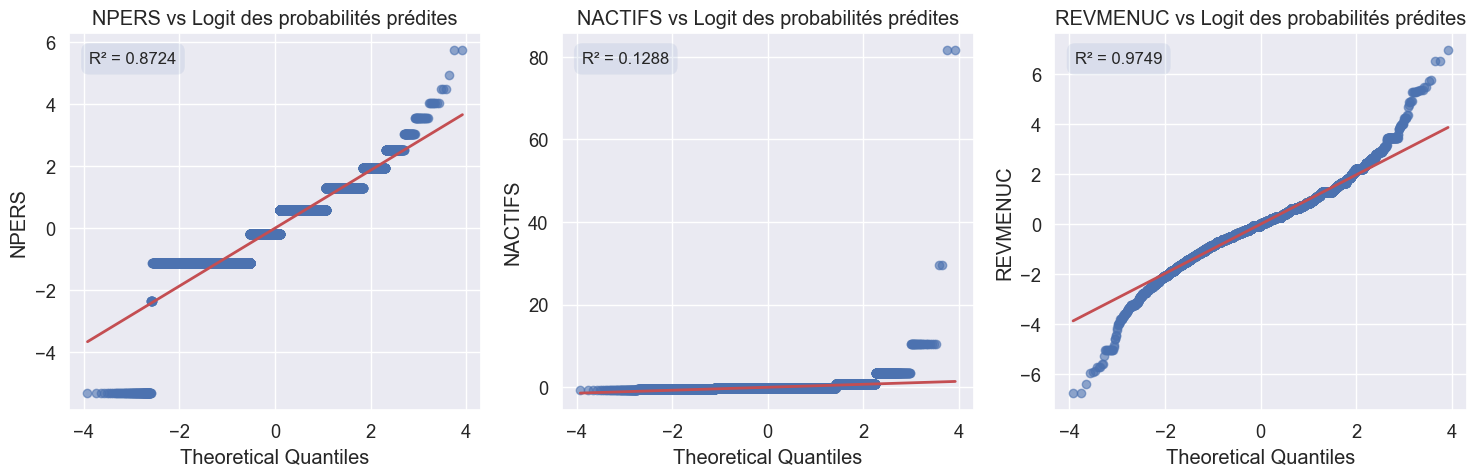

In [18]:
from scipy.stats import boxcox

def transform_data(df): 
    df['REVMENUC'] = np.log(df['REVMENUC'])
    df['NACTIFS'] = np.exp(df['NACTIFS'])
    
    # Nettoyer les données
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
   
    df['NPERS'] = np.sqrt(df['NPERS'])
    

    final_df = df.copy()
    return final_df 

final_df = transform_data(df)

def check_linearity_in_logit(final_df, numericals, target='FPA'):
     
    # Ajouter une constante au DataFrame
    df = sm.add_constant(final_df)
    
    # Ajuster le modèle de régression logistique
    logit_model = sm.Logit(df[target], df[numericals])
    logit_results = logit_model.fit(disp=0)
    
    # Calculer les probabilités prédites en logit
    predicted_logit = logit_results.predict()
    
    # Tracer les graphiques de dispersion
    fig, axes = plt.subplots(nrows=1, ncols=len(numericals), figsize=(15, 5))
    
    for i, var in enumerate(numericals):
        # Tracer le graphique de dispersion (variable continue vs logit des probabilités prédites)
        probplot = ProbPlot(df[var], fit=True)
        axes[i].scatter(probplot.theoretical_quantiles, probplot.sample_quantiles, alpha=0.6)
        axes[i].set_title(f"{var} vs Logit des probabilités prédites")
        axes[i].set_xlabel(f"Theoretical Quantiles")
        axes[i].set_ylabel(f"{var}")
        axes[i].grid(True)
        
        # Ajouter la droite de régression linéaire
        fit = np.polyfit(probplot.theoretical_quantiles, probplot.sample_quantiles, 1)
        fit_values = np.polyval(fit, probplot.theoretical_quantiles)
        axes[i].plot(probplot.theoretical_quantiles, fit_values, 'r-', linewidth=2)
        
        # Calculer le R² pour la linéarité
        r2 = r2_score(probplot.sample_quantiles, fit_values)
        
        # Afficher le R² sur le graphique
        axes[i].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[i].transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1))
    
    plt.tight_layout()
    plt.show()


# Appeler la fonction pour vérifier la linéarité en logit pour les variables continues
check_linearity_in_logit(final_df, numericals, target='FPA')


### (7) Validation du modèle

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24024 entries, 2 to 33672
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NPERS      24024 non-null  float64
 1   NACTIFS    24024 non-null  float64
 2   REVMENUC   24024 non-null  float64
 3   LIENPREF   24024 non-null  object 
 4   CJSITUA    24024 non-null  object 
 5   STATUTEXT  24024 non-null  object 
 6   TYPMEN15   24024 non-null  object 
 7   METIER     24024 non-null  object 
 8   RABS       24024 non-null  object 
 9   AGEQ       24024 non-null  object 
 10  TRANCHRE   24024 non-null  object 
 11  SITUA      24024 non-null  object 
 12  LIEN_01    24024 non-null  object 
 13  ETAMATRI   24024 non-null  object 
 14  FPA        24024 non-null  int64  
dtypes: float64(3), int64(1), object(11)
memory usage: 2.9+ MB


In [20]:
def final_model(final_df, numericals, categoricals, target='FPA', num_groups=10):
    
    df = sm.add_constant(final_df)
        
    exog_numericals = df[numericals].values                                             # Sélectionner les variables explicatives pour le modèle de régression logistique
    exog_categoricals = pd.get_dummies(df[categoricals], drop_first=True).values
    
    scaler = StandardScaler()
    exog_numericals_scaled = scaler.fit_transform(exog_numericals)
    
    exog = np.concatenate((exog_numericals_scaled, exog_categoricals), axis=1)                 # Combiner les variables explicatives
        
    model = sm.Logit(df[target], exog)      # Ajuster le modèle de régression logistique
    results = model.fit_regularized(maxiter=1000, alpha=0.00000001)
    
    residuals = results.resid_pearson
       
    # TEST DE Durbin-Watson
    durbin_watson_statistic = durbin_watson(residuals)
    print(f"\n-----------------------------------------------------------------------------\nStatistique de Durbin-Watson : {durbin_watson_statistic:.4f}")
        
    if durbin_watson_statistic < 1.5:
        print("Les résidus montrent une autocorrélation positive.\n")
    elif durbin_watson_statistic > 2.5:
        print("Les résidus montrent une autocorrélation négative.\n")
    else:
        print("Les résidus ne montrent pas d'autocorrélation significative.\n")

    # TEST DE HOSMER-LEMESHOW
    y_true = df[target].values
    y_prob = results.predict(exog)

    # Vérification des dimensions des données
    if len(y_true) != len(y_prob):
        raise ValueError("Les dimensions de y_true et y_prob doivent être identiques.")
    
    # Créer les groupes en fonction des probabilités prédites
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    deciles = np.percentile(y_prob, np.arange(0, 100, 100/num_groups))
    groups = np.digitize(y_prob, deciles)
    
    # Initialisation des tableaux pour les fréquences observées et attendues
    obs_freq = np.zeros(num_groups)
    exp_freq = np.zeros(num_groups)
    
    # Calcul des fréquences observées et attendues pour chaque groupe
    for i in range(num_groups):
        obs_freq[i] = np.sum((groups == (i + 1)) * y_true)
        exp_freq[i] = np.sum(groups == (i + 1)) * np.mean(y_true)
    
    chi2_statistic = np.sum((obs_freq - exp_freq)**2 / exp_freq)        # Calcul de la statistique de test de Hosmer-Lemeshow
    df_hl = num_groups - 2      # Degré de liberté est (num_groups - 2) car il y a num_groups - 1 groupes et 2 paramètres (intercept et pente)
    p_value_hl = 1 - chi2.cdf(chi2_statistic, df_hl)    # Calcul de la valeur p

    print(f"\n-----------------------------------------------------------------------------\nStatistique du test de Hosmer-Lemeshow : {chi2_statistic:.4f}")
    print(f"Valeur p : {p_value_hl:.4f}")

    # Interpréter les résultats du test de Hosmer-Lemeshow
    if p_value_hl < 0.05:
        print("Le modèle ne correspond pas bien aux données observées (rejet de l'hypothèse nulle).\n")
    else:
        print("Le modèle correspond bien aux données observées (absence de preuve pour rejeter l'hypothèse nulle).\n")
    
    # VALIDATION DU MODÈLE
    # Séparer les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(exog, df[target], test_size=0.2, random_state=42)
    
    # Perform cross-validation with LogisticRegression from scikit-learn
    logreg = LogisticRegression()
    
    # Fit the model on training data
    logreg.fit(X_train, y_train)
    
    # Perform cross-validation
    accuracy_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')
    recall_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall')
    roc_auc_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Calculate mean scores
    mean_accuracy = accuracy_scores.mean()
    mean_precision = precision_scores.mean()
    mean_recall = recall_scores.mean()
    mean_roc_auc = roc_auc_scores.mean()
    
    # Print the results
    print("\n----------------------------------")
    print("Validation du modèle avec cross-validation :")
    print(f"Accuracy : {mean_accuracy:.4f}")
    print(f"Precision : {mean_precision:.4f}")
    print(f"Recall : {mean_recall:.4f}")
    print(f"AUC-ROC : {mean_roc_auc:.4f}")
    
    # Return or print results as needed
    results = {
        'Accuracy': mean_accuracy,
        'Precision': mean_precision,
        'Recall': mean_recall,
        'AUC-ROC': mean_roc_auc
    }

    return y_true, y_prob

# Appeler la fonction pour ajuster le modèle final
y_true, y_prob = final_model(final_df, numericals, categoricals, target='FPA', num_groups=10)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4304109708627667
            Iterations: 578
            Function evaluations: 578
            Gradient evaluations: 578

-----------------------------------------------------------------------------
Statistique de Durbin-Watson : 1.8389
Les résidus ne montrent pas d'autocorrélation significative.


-----------------------------------------------------------------------------
Statistique du test de Hosmer-Lemeshow : 3403.0759
Valeur p : 0.0000
Le modèle ne correspond pas bien aux données observées (rejet de l'hypothèse nulle).



/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 95 out of 95 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/mariusayrault/GitHub/Sorb-Data-Analytics/projet-statistique/.venv/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)



----------------------------------
Validation du modèle avec cross-validation :
Accuracy : 0.8155
Precision : 0.6974
Recall : 0.2379
AUC-ROC : 0.7662



Hypothèses :
- H0 : La femme n'est pas le principal apporteur de ressources au sein du ménage.
- H1 : La femme est le principal apporteur de ressources au sein du ménage.

76.71% (Vrais négatifs) 		 2.15% (Faux positifs)
15.93% (Faux négatifs) 		 5.21% (Vrais positifs)

Interprétation de H0 :
- Vrais négatifs 76.71 % (Femmes correctement identifiées comme non principale apporteur de ressources selon H0)
- Faux positifs 2.15 % (Femmes incorrectement identifiées comme principale apporteur de ressources selon H0)

Interprétation de H1 :
- Vrais positifs 5.21 % (Femmes correctement identifiées comme principale apporteur de ressources selon H1)
- Faux négatifs 15.93 % (Femmes incorrectement identifiées comme non principale apporteur de ressources selon H1)


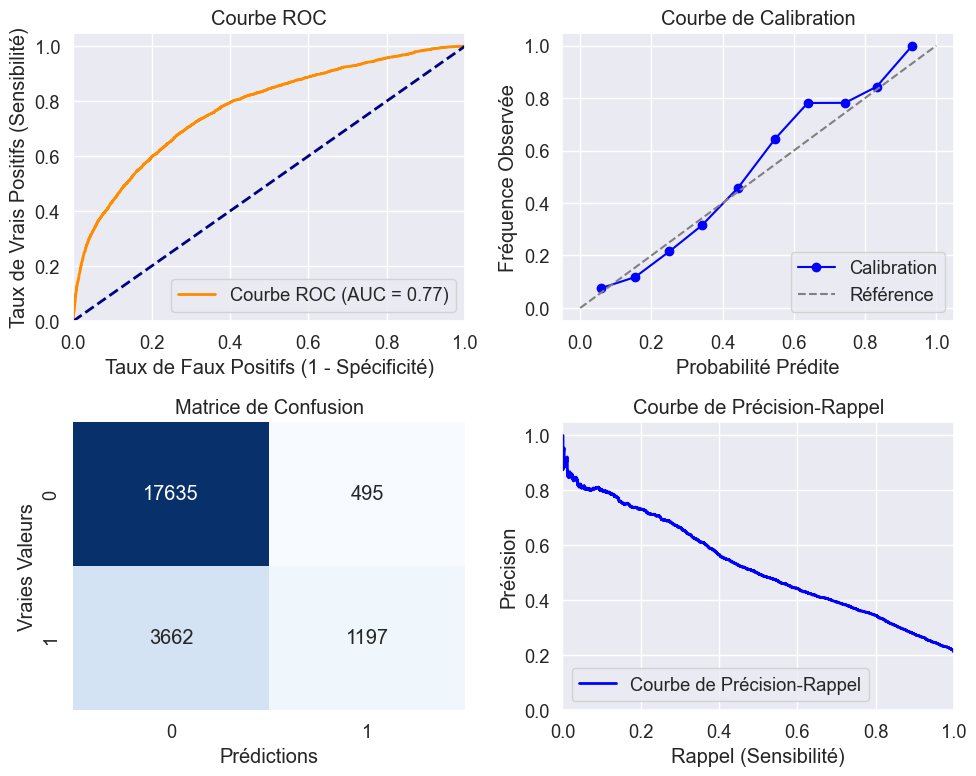

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(ax, y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Taux de Faux Positifs (1 - Spécificité)')
    ax.set_ylabel('Taux de Vrais Positifs (Sensibilité)')
    ax.set_title('Courbe ROC')
    ax.legend(loc="lower right")



def plot_calibration_curve(ax, y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', color='blue', label='Calibration')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Référence')
    ax.set_xlabel('Probabilité Prédite')
    ax.set_ylabel('Fréquence Observée')
    ax.set_title('Courbe de Calibration')
    ax.legend(loc="lower right")


def plot_confusion_matrix(ax, y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    cm_percent = cm / cm.sum() * 100

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vraies Valeurs')
    ax.set_title('Matrice de Confusion')

    # Interprétation spécifique à l'objectif
    # Hypothèses
    print("\nHypothèses :")
    print("- H0 : La femme n'est pas le principal apporteur de ressources au sein du ménage.")
    print("- H1 : La femme est le principal apporteur de ressources au sein du ménage.\n")

 
    print(f"{cm_percent[(0, 0)]:.2f}% (Vrais négatifs) \t\t {cm_percent[(0, 1)]:.2f}% (Faux positifs)")
    print(f"{cm_percent[(1, 0)]:.2f}% (Faux négatifs) \t\t {cm_percent[(1, 1)]:.2f}% (Vrais positifs)")

    # Explications pour H0
    print("\nInterprétation de H0 :")
    print(f"- Vrais négatifs {cm_percent[(0, 0)]:.2f} % (Femmes correctement identifiées comme non principale apporteur de ressources selon H0)")
    print(f"- Faux positifs {cm_percent[(0, 1)]:.2f} % (Femmes incorrectement identifiées comme principale apporteur de ressources selon H0)")

    # Explications pour H1
    print("\nInterprétation de H1 :")
    print(f"- Vrais positifs {cm_percent[(1, 1)]:.2f} % (Femmes correctement identifiées comme principale apporteur de ressources selon H1)")
    print(f"- Faux négatifs {cm_percent[(1, 0)]:.2f} % (Femmes incorrectement identifiées comme non principale apporteur de ressources selon H1)")

def plot_precision_recall_curve(ax, y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    ax.plot(recall, precision, color='blue', lw=2, label='Courbe de Précision-Rappel')
    ax.set_xlabel('Rappel (Sensibilité)')
    ax.set_ylabel('Précision')
    ax.set_title('Courbe de Précision-Rappel')
    ax.legend(loc="lower left")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])


# Créer la figure et les sous-graphiques
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Premier sous-plot : plot_roc_curve
plot_roc_curve(axs[0, 0], y_true, y_prob)

# Deuxième sous-plot : plot_calibration_curve
plot_calibration_curve(axs[0, 1], y_true, y_prob)

# Troisième sous-plot : plot_confusion_matrix
plot_confusion_matrix(axs[1, 0], y_true, y_prob)

# Quatrième sous-plot : plot_precision_recall_curve
plot_precision_recall_curve(axs[1, 1], y_true, y_prob)

# Ajuster automatiquement les paramètres de la figure pour éviter les chevauchements
plt.tight_layout()
plt.show()

## Export Notebook.pdf 

In [22]:
import nbformat
from nbconvert import HTMLExporter
from weasyprint import HTML
import sys

notebook_path = 'Notebook_regression_logistique.ipynb'
output_pdf_path = './data/Notebook.pdf'

def convert_notebook_to_pdf(notebook_path, output_pdf_path):
    # Lire le fichier notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)

    # Convertir le notebook en HTML
    html_exporter = HTMLExporter()
    html_data, _ = html_exporter.from_notebook_node(notebook)

    # Sauvegarder le HTML dans un fichier temporaire
    temp_html_path = notebook_path.replace('.ipynb', '.html')
    with open(temp_html_path, 'w', encoding='utf-8') as f:
        f.write(html_data)

    # Convertir le fichier HTML en PDF
    HTML(temp_html_path).write_pdf(output_pdf_path)

    print(f"Conversion terminée : {output_pdf_path}")

convert_notebook_to_pdf(notebook_path, output_pdf_path)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
1 extra bytes in post.stringData array


Conversion terminée : ./data/Notebook.pdf
